### Categories of Services Shortage Classification (LGBM Multi-Class)

1. Data was first pre-processed and load the final version of la_facility_mua.csv here

2. Since feature engineering has been done, a few touch-ups before training:

a) **Feature Mapping,**

b) **Dropping useless variables,**

c) **Datetime conversion,**

d) **Days Diff**

3. We have **3 main types of Services (Target variable: Category Service)**

a) **Health and Mental Health**

b) **Social Services**

c) **Public Safety**

4. Data was split into Train and Validation

5. Model: **LGBM**

6. 2 Methods:

a) Simple train-test-split
 
b) 6-StratifiedKFold

In [2]:
import os
os.environ['PYTHONHASHSEED']='0'

In [3]:
import pandas as pd
import numpy as np
import random as rn
# Deep Learning Libraries
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import Conv1D,MaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import tensorflow as tf
np.random.seed(37)
rn.seed(42)
tf.random.set_seed(42)
from keras import backend as K

Using TensorFlow backend.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
from math import sqrt 
from sklearn.metrics import log_loss
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc,roc_auc_score
from catboost import CatBoostClassifier,Pool, cv
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

la_facility_mua = pd.read_csv('../input/la-final-data-2/la_facility_mua.csv')

In [5]:
la_facility_mua.head()

,source,cat1,cat2,org_name,Name,addrln1,city,state,post_id,description,...,facility_address_1,MUA_RuralStatus,MUA_Designated_Time,MUA_Designated_Date,MUA_MSSA_Name_1,MUA_Updated_Time,MUA_Updated_Date,MUA_Poverty,MUA_Score,MUA_Pct_100Poverty
0,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,415 South Union Avenue,Urban,1.067990e+12,2003-11-05,MSSA 78.2b (Pico Union/Westlake),1.067990e+12,2003-11-05,157757.0,51.0,0.0
1,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,600 St Paul Ave,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
2,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1125 W 6th St,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
3,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1225 Wilshire Boulevard,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
4,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1127 Wilshire Blvd,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0


In [9]:
la_facility_mua.rename({'cat1': 'Category Service'}, axis=1, inplace=True)

#### We will use 'Service Category' as our target variable

In [10]:
la_facility_mua['Category Service'].value_counts().sort_values(ascending=False)

Health and Mental Health    4858
Social Services             4330
Public Safety               1317
Name: Category Service, dtype: int64

In [11]:
la_facility_mua['Category Service']=la_facility_mua['Category Service'].map({
'Health and Mental Health':0,
'Social Services':1,
'Public Safety':2
})
la_facility_mua['Category Service']=la_facility_mua['Category Service'].astype('int32')

In [13]:
la_facility_mua['facility_er_service'] = la_facility_mua['facility_er_service'].map({
'Not Applicable':'Not Applicable',
'None':'Not Applicable',
'Emergency - Basic':'Emergency',
'Emergency - Comprehensive':'Emergency',
'Emergency - Standby':'Emergency'
})

In [14]:
la_facility_mua['MUA_Poverty']=la_facility_mua['MUA_Poverty'].map({
157757.0:2,
129447.0:1,
0.0:0,
})

In [19]:
la_facility_mua['MUA_Designated_Date'] = pd.to_datetime(la_facility_mua['MUA_Designated_Date']) 
la_facility_mua['MUA_Updated_Date'] = pd.to_datetime(la_facility_mua['MUA_Updated_Date']) 
la_facility_mua['Date Difference'] = la_facility_mua['MUA_Updated_Date']-la_facility_mua['MUA_Designated_Date']

In [20]:
def ddiff2days(ddiff):
    if not pd.isnull(ddiff):
        return pd.Timedelta.total_seconds(ddiff)/(24.*3600)
    else:
        return np.NaN

In [21]:
la_facility_mua['Date Difference']=la_facility_mua['Date Difference'].apply(ddiff2days)
la_facility_mua['Date Difference']=la_facility_mua['Date Difference'].astype('int32')

In [22]:
la_facility_mua['design_year'] = (la_facility_mua['MUA_Designated_Date'].dt.year).astype('int32')
la_facility_mua['design_month'] = (la_facility_mua['MUA_Designated_Date'].dt.month).astype('int32')
la_facility_mua['design_week'] = (la_facility_mua['MUA_Designated_Date'].dt.week).astype('int32')
la_facility_mua['design_dow'] = (la_facility_mua['MUA_Designated_Date'].dt.dayofweek).astype('int32')

la_facility_mua['update_year'] = (la_facility_mua['MUA_Updated_Date'].dt.year).astype('int32')
la_facility_mua['update_month'] = (la_facility_mua['MUA_Updated_Date'].dt.month).astype('int32')
la_facility_mua['update_week'] = (la_facility_mua['MUA_Updated_Date'].dt.week).astype('int32')
la_facility_mua['update_dow'] = (la_facility_mua['MUA_Updated_Date'].dt.dayofweek).astype('int32')

In [24]:
la_facility_mua.drop(['MUA_Designated_Date', 'MUA_Updated_Date',                     
 ], axis=1, inplace=True)

In [25]:
cols = [c for c in la_facility_mua.columns if la_facility_mua[c].dtypes=='object']
for c in cols:
    le = LabelEncoder()
    la_facility_mua[c] = (le.fit_transform(la_facility_mua[c])).astype('int32')

In [27]:
X = la_facility_mua.drop(labels=['Category Service'], axis=1)
y = la_facility_mua['Category Service']

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=tf.random.set_seed(42))

In [28]:
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'num_iterations': 800,
         'num_leaves': 31,
         'max_depth': -1,
         'learning_rate': 0.01, 
         'num_class': 3,
         'objective': 'multiclass',
         'metric': 'multi_logloss',
         'min_data_per_group': 80,
         'feature_fraction': 0.4,
         'bagging_fraction':0.5,
         'bagging_freq': 5,
         'boosting': 'gbdt',
         'is_unbalance':True
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=20,
                verbose_eval=100,
                train_set=train_data,
                valid_sets=[train_data, test_data])

y_pred = clf.predict(X_cv)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds
[100]	training's multi_logloss: 0.359722	valid_1's multi_logloss: 0.362897
[200]	training's multi_logloss: 0.14356	valid_1's multi_logloss: 0.146571
[300]	training's multi_logloss: 0.0596748	valid_1's multi_logloss: 0.0614401
[400]	training's multi_logloss: 0.0259907	valid_1's multi_logloss: 0.0269914
[500]	training's multi_logloss: 0.0111178	valid_1's multi_logloss: 0.0116297
[600]	training's multi_logloss: 0.00462279	valid_1's multi_logloss: 0.0048732
[700]	training's multi_logloss: 0.00203674	valid_1's multi_logloss: 0.00215985
[800]	training's multi_logloss: 0.000941833	valid_1's multi_logloss: 0.00100505
Did not meet early stopping. Best iteration is:
[800]	training's multi_logloss: 0.000941833	valid_1's multi_logloss: 0.00100505


In [29]:
log_loss(y_cv, y_pred)

0.0010050492112406231

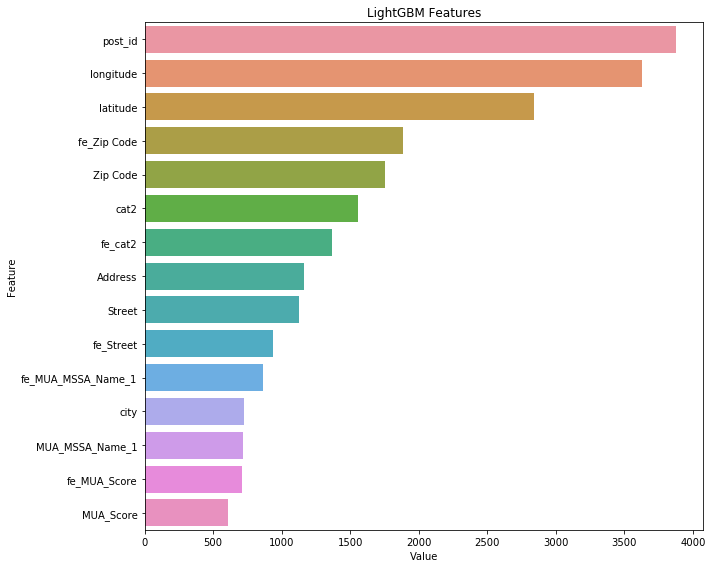

In [30]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), X.columns), reverse=True)[:15],
                           columns=['Value','Feature'])
plt.figure(figsize=(10,8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [31]:
err = []
fold = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
for train_index, test_index in fold.split(X, y):
    
    X_train, X_cv = X.loc[train_index], X.loc[test_index]
    y_train, y_cv = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_cv, label=y_cv)
    
    clf = lgb.train(params=param, 
                     early_stopping_rounds=100,
                     verbose_eval=50,
                     train_set=train_data,
                     valid_sets=[train_data, val_data])

    y_pred = clf.predict(X_cv)
    print("Log Loss: ", (log_loss(y_cv, y_pred)))
    err.append(log_loss(y_cv, y_pred))

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[50]	training's multi_logloss: 0.586474	valid_1's multi_logloss: 0.587292
[100]	training's multi_logloss: 0.359991	valid_1's multi_logloss: 0.360585
[150]	training's multi_logloss: 0.22544	valid_1's multi_logloss: 0.226085
[200]	training's multi_logloss: 0.143824	valid_1's multi_logloss: 0.14444
[250]	training's multi_logloss: 0.0871026	valid_1's multi_logloss: 0.0875801
[300]	training's multi_logloss: 0.0599173	valid_1's multi_logloss: 0.0603686
[350]	training's multi_logloss: 0.0400665	valid_1's multi_logloss: 0.0404626
[400]	training's multi_logloss: 0.0261205	valid_1's multi_logloss: 0.026428
[450]	training's multi_logloss: 0.0168463	valid_1's multi_logloss: 0.0170882
[500]	training's multi_logloss: 0.0111636	valid_1's multi_logloss: 0.0113499
[550]	training's multi_logloss: 0.00694023	valid_1's multi_logloss: 0.00707795
[600]	training's multi_logloss: 0.00463919	valid_1's multi_logloss: 0.00474377
[650]	training's multi

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's multi_logloss: 0.585498	valid_1's multi_logloss: 0.587467
[100]	training's multi_logloss: 0.359288	valid_1's multi_logloss: 0.362248
[150]	training's multi_logloss: 0.224706	valid_1's multi_logloss: 0.227479
[200]	training's multi_logloss: 0.143287	valid_1's multi_logloss: 0.145526
[250]	training's multi_logloss: 0.0866886	valid_1's multi_logloss: 0.0883543
[300]	training's multi_logloss: 0.0595554	valid_1's multi_logloss: 0.0608585
[350]	training's multi_logloss: 0.039859	valid_1's multi_logloss: 0.0408841
[400]	training's multi_logloss: 0.0259456	valid_1's multi_logloss: 0.0267152
[450]	training's multi_logloss: 0.0167556	valid_1's multi_logloss: 0.0172854
[500]	training's multi_logloss: 0.0110988	valid_1's multi_logloss: 0.0114707
[550]	training's multi_logloss: 0.00690426	valid_1's multi_logloss: 0.00716114
[600]	training's multi_logloss: 0.0046156	valid_1's multi_logloss: 0.00480218
[650]	training's multi_logloss: 0.00302707	valid_1's multi_logloss: 0.00315875
[700

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's multi_logloss: 0.585687	valid_1's multi_logloss: 0.590377
[100]	training's multi_logloss: 0.359231	valid_1's multi_logloss: 0.365272
[150]	training's multi_logloss: 0.224598	valid_1's multi_logloss: 0.22979
[200]	training's multi_logloss: 0.143161	valid_1's multi_logloss: 0.147429
[250]	training's multi_logloss: 0.086615	valid_1's multi_logloss: 0.089747
[300]	training's multi_logloss: 0.0594906	valid_1's multi_logloss: 0.0619503
[350]	training's multi_logloss: 0.0398006	valid_1's multi_logloss: 0.0416082
[400]	training's multi_logloss: 0.0259144	valid_1's multi_logloss: 0.0271748
[450]	training's multi_logloss: 0.0167411	valid_1's multi_logloss: 0.0176163
[500]	training's multi_logloss: 0.0110867	valid_1's multi_logloss: 0.0116989
[550]	training's multi_logloss: 0.00689385	valid_1's multi_logloss: 0.00730458
[600]	training's multi_logloss: 0.00460996	valid_1's multi_logloss: 0.00490003
[650]	training's multi_logloss: 0.0030236	valid_1's multi_logloss: 0.00322026
[700]	

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's multi_logloss: 0.585742	valid_1's multi_logloss: 0.588008
[100]	training's multi_logloss: 0.359568	valid_1's multi_logloss: 0.362582
[150]	training's multi_logloss: 0.225268	valid_1's multi_logloss: 0.227976
[200]	training's multi_logloss: 0.143665	valid_1's multi_logloss: 0.14596
[250]	training's multi_logloss: 0.0870429	valid_1's multi_logloss: 0.0887567
[300]	training's multi_logloss: 0.0597868	valid_1's multi_logloss: 0.0611889
[350]	training's multi_logloss: 0.0399685	valid_1's multi_logloss: 0.04104
[400]	training's multi_logloss: 0.0260259	valid_1's multi_logloss: 0.026808
[450]	training's multi_logloss: 0.0167901	valid_1's multi_logloss: 0.0173551
[500]	training's multi_logloss: 0.0111399	valid_1's multi_logloss: 0.011545
[550]	training's multi_logloss: 0.00692901	valid_1's multi_logloss: 0.00719974
[600]	training's multi_logloss: 0.00462896	valid_1's multi_logloss: 0.00482667
[650]	training's multi_logloss: 0.00303436	valid_1's multi_logloss: 0.00317217
[700]	t

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's multi_logloss: 0.585249	valid_1's multi_logloss: 0.588894
[100]	training's multi_logloss: 0.359178	valid_1's multi_logloss: 0.363221
[150]	training's multi_logloss: 0.224522	valid_1's multi_logloss: 0.228094
[200]	training's multi_logloss: 0.143403	valid_1's multi_logloss: 0.14615
[250]	training's multi_logloss: 0.0867589	valid_1's multi_logloss: 0.0887536
[300]	training's multi_logloss: 0.0596773	valid_1's multi_logloss: 0.0612585
[350]	training's multi_logloss: 0.0399137	valid_1's multi_logloss: 0.0411279
[400]	training's multi_logloss: 0.0259853	valid_1's multi_logloss: 0.0268665
[450]	training's multi_logloss: 0.0167868	valid_1's multi_logloss: 0.0174151
[500]	training's multi_logloss: 0.0111215	valid_1's multi_logloss: 0.0115724
[550]	training's multi_logloss: 0.00691614	valid_1's multi_logloss: 0.00722248
[600]	training's multi_logloss: 0.00462197	valid_1's multi_logloss: 0.0048438
[650]	training's multi_logloss: 0.00303334	valid_1's multi_logloss: 0.0031905
[700]

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[50]	training's multi_logloss: 0.586415	valid_1's multi_logloss: 0.588718
[100]	training's multi_logloss: 0.360297	valid_1's multi_logloss: 0.363521
[150]	training's multi_logloss: 0.225381	valid_1's multi_logloss: 0.22847
[200]	training's multi_logloss: 0.143736	valid_1's multi_logloss: 0.1464
[250]	training's multi_logloss: 0.0869229	valid_1's multi_logloss: 0.0888272
[300]	training's multi_logloss: 0.0597729	valid_1's multi_logloss: 0.0613922
[350]	training's multi_logloss: 0.0400065	valid_1's multi_logloss: 0.0412266
[400]	training's multi_logloss: 0.0260522	valid_1's multi_logloss: 0.0269319
[450]	training's multi_logloss: 0.0168046	valid_1's multi_logloss: 0.017426
[500]	training's multi_logloss: 0.0111302	valid_1's multi_logloss: 0.0115857
[550]	training's multi_logloss: 0.00692648	valid_1's multi_logloss: 0.00722555
[600]	training's multi_logloss: 0.00462738	valid_1's multi_logloss: 0.0048384
[650]	training's multi_logloss: 0.00303487	valid_1's multi_logloss: 0.00318296
[700]	t

In [32]:
np.mean(err,0)

0.000995524215334025